In [43]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz
from skycam_utils.photometry import load_skycam_catalog
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

Load the curated skycam catalog that contains photometry, names, positions, and other info for naked eye stars into `skycat`. Then load the catalog for the calibration image into `srccat`. This catalog is created using `photutils` to find sources and measure their properties. For the calibration image, the sources will need to be hand-labeled so they can be cross-referenced with `skycat`. Once an initial WCS is built from this, it should be possible to make refined or updated WCS's from that without having to do the hand-labeling step. The `id` column created by `photutils` needs to be renamed to `Star Name` to match the name used in `skycat`.

In [2]:
skycat = load_skycam_catalog()
srccat = Table.read("sources.csv")
srccat.rename_column('id', 'Star Name')
srccat

Star Name,xcentroid,ycentroid,source_sum,background_mean,obs_mag
str16,float64,float64,int64,float64,float64
Arcturus,205.75093674234074,186.52038792153405,4537,34.072269285623705,-9.141921948165042
Spica,261.365227537923,72.07613768961494,3428,35.52773780456124,-8.8376020331279
Alioth,276.6132148377125,324.4161514683153,2588,31.772967317974416,-8.532410679991656
Regulus,434.3867469879518,188.76546184738956,2490,33.24672180270213,-8.490498367739342
Procyon,549.9348088531187,235.30060362173037,2485,30.08731424218419,-8.488315982673377
Mizar,259.931453362256,320.90498915401304,2305,32.50652040965434,-8.406677324314169
Castor,496.75752289576974,328.77409507195813,2293,34.49127850836499,-8.401010136824848
Dubhe,328.9028021015762,354.04772329246936,2284,33.406627069777215,-8.396740248934528
Algieba,415.7543780871127,213.6044005388415,2227,34.48611836238509,-8.369300542585096


This is an example of a clear, dark image and its header. The `UT` is needed to calculate the Alt/Az for the catalog stars.

In [3]:
hdul = fits.open("image_0003000.fits")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
UT      = 'WED MAR 06 08:30:37 2019'                                            
LST     = '12:02:13.796'                                                        
AZ      =         185.47722725                                                  
EL      =    66.31854970000001                                                  
SCOPEX  =                  3

I don't understand why people don't simply use ISO format for time strings. It is so much easier and universally understood. So we parse what we have into `datetime` and make a `Time` object from that.

In [4]:
dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(dt, scale='utc')
tobs

<Time object: scale='utc' format='datetime' value=2019-03-06 08:30:37>

Use the `update_altaz` function to update the `Alt` and `Az` columns in `skycat` based on `tobs`. The columns will be added if they don't exist.

In [5]:
skycat = update_altaz(skycat, time=tobs)

Join the catalogs based on `Star Name` and keep the most relevant columns.

In [6]:
joint = join(skycat, srccat, keys='Star Name', join_type='inner')
joint.keep_columns(['Star Name', 'Identity', 'xcentroid', 'ycentroid', 'Magnitude', 'obs_mag', 'background_mean', 'RA', 'Dec', 'Alt', 'Az'])
joint.sort('Magnitude')
joint

Star Name,Identity,Magnitude,RA,Dec,Alt,Az,xcentroid,ycentroid,background_mean,obs_mag
,,,,,deg,deg,,,,
str17,str25,float64,float64,float64,float64,float64,float64,float64,float64,float64
Arcturus,Alpha Bodtis,-0.04,213.9153003,19.1824092,57.32121256443195,104.50408885481916,205.75093674234074,186.52038792153405,34.072269285623705,-9.141921948165042
Capella,Alpha Aurigae,0.08,79.1723281,45.9979914,15.360727507827027,315.0222717817872,467.29929221435793,433.4398382204247,27.342272140302846,-7.487990728992948
Procyon,Alpha Canis Minoris,0.38,114.8254978,5.2249875,23.52464051792173,261.1953470865173,549.9348088531187,235.30060362173037,30.08731424218419,-8.488315982673377
Spica,Alpha Virginis,0.98,201.29825,-11.1613833,42.57479490810877,151.49845487137017,261.365227537923,72.07613768961494,35.52773780456124,-8.8376020331279
Pollux,Beta Geminorum,1.14,116.3289578,28.0261989,35.21611703580833,283.8332732009207,502.692131747484,311.0292772186642,33.969814105932294,-8.34912539403421
Regulus,Alpha Leonis,1.35,152.0929625,11.9672089,57.340881608408296,238.99558487596556,434.3867469879518,188.76546184738956,33.24672180270213,-8.490498367739342
Alioth,Epsilon Ursae Majoris,1.77,193.507,55.9597167,64.13431902820338,17.036415663962096,276.6132148377125,324.4161514683153,31.772967317974416,-8.532410679991656
Dubhe,Alpha Ursae Majoris,1.79,165.9319647,61.7510347,58.62953692447192,346.9540840853105,328.9028021015762,354.04772329246936,33.406627069777215,-8.396740248934528


Do the WCS fit with a reasonable guess for initial parameters. 

In [39]:
fun = wcs_zea(joint['xcentroid'], joint['ycentroid'], joint['Alt'], joint['Az'], crpix1=324, crpix2=235, a_order=2, b_order=2)
init = np.array([324, 235, 1, 1, 0.3, 0.003, 0.003, 0.3])
sip_init = np.zeros(18)
x0 = np.append(init, sip_init)
x0 = init
fit_result = minimize(fun, x0)


A little confusing to use RA and DEC when we're actually doing Alt and Az. This fit seems to work, though, and the numbers look reasonable.

In [40]:
wcs_initial = fun.return_wcs(fit_result.x)
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 320.6266822155555  236.19084807882237  
PC1_1 PC1_2  : 0.2850270507349917  0.04399450645990585  
PC2_1 PC2_2  : -0.040385428978139806  0.2675050084649244  
CDELT : 0.9246834882139586  0.984236347125948  
NAXIS : 0  0

The residuals look pretty good, too. The only significant outliers are the ones at the very edge of the field of view. 

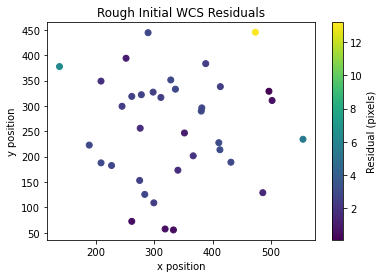

In [41]:
fit_x, fit_y = wcs_initial.all_world2pix(joint['Az'], joint['Alt'], 0)
resid_d = ((fit_x-joint['xcentroid'])**2+(fit_y-joint['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [46]:
resid_d[resid_d < 10].mean()

2.3929027475422258

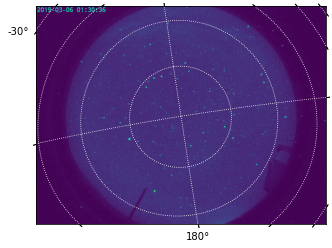

In [22]:
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
plt.show()

In [23]:
ax.coords

<CoordinatesMap with 2 world coordinates:

  index           aliases              type   unit wrap format_unit visible
  ----- --------------------------- --------- ---- ---- ----------- -------
      0   pos.eq.ra ra---zea-sip ra longitude  deg  360         deg     yes
      1 pos.eq.dec dec--zea-sip dec  latitude  deg None         deg     yes

>

In [45]:
wcs_fits = wcs_initial.to_fits()
wcs_fits.writeto("wcs.fits")

In [44]:
test = WCS("wcs.fits")

In [47]:
joint.write("astrometry.csv")

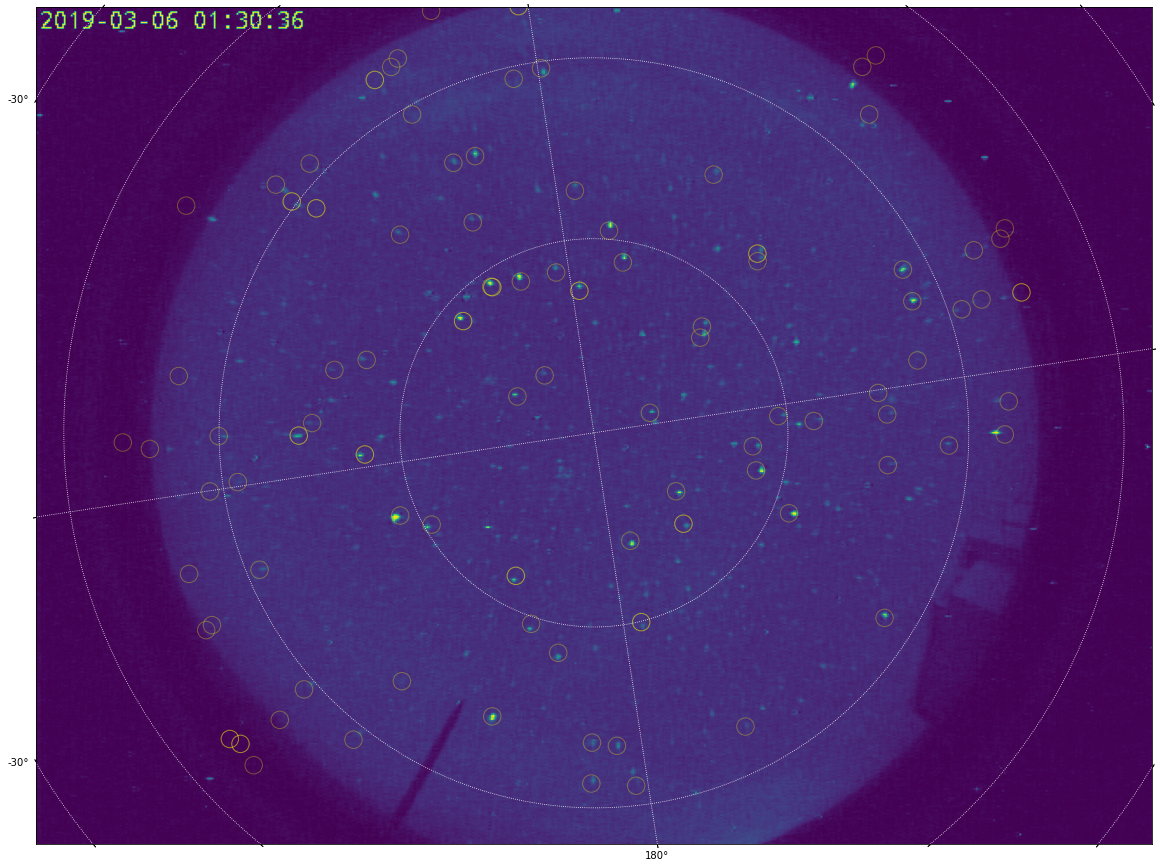

In [50]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
#aps.plot(color='red', lw=1.5, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()